In [415]:
using Graphs
using Plots
using GraphRecipes
using StatsBase
using Distances
using Distributions
gr()

default(; dpi=300, fg_legend=:transparent)

In [7]:
function random_close_link_graph(d, deg)
    N = size(d, 1)
    g = Graph(N)
    
    stopper = 1_000_000
    while 2 * ne(g) < N * deg
        w = 1 .- cdf.(Poisson(deg), degree(g))
        i = sample(1:N, Weights(w))
        j = sample(1:N, Weights(d[i, :]))
        add_edge!(g, i, j)
        stopper -= 1
        if stopper == 0
            break
        end
    end
    g
end

random_close_link_graph (generic function with 1 method)

In [67]:
N = 200
x = rand(N)
y = rand(N);
d = pairwise(Euclidean(), [x'; y'])
d[CartesianIndex.(1:N, 1:N)] .= Inf
d = pdf.(Normal(0., 0.1), d)
g = random_close_link_graph(d, 4)
is_connected(g) || error()

true

In [68]:
g

{200, 400} undirected simple Int64 graph

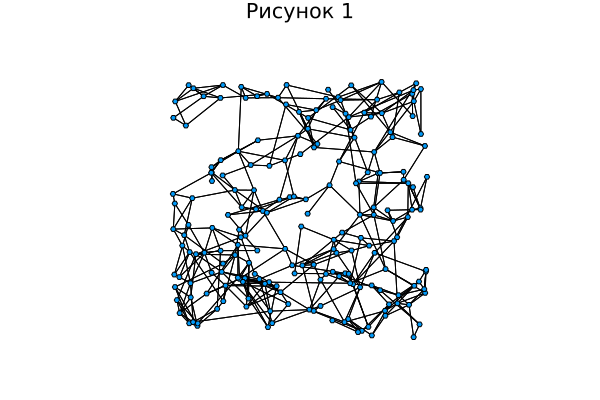

In [386]:
plot(g; x, y, curves=false, title="Рисунок 1")
savefig("graph.png")
plot!()

In [13]:
distance(a, i, j) = a.dists[i, j]

distance (generic function with 1 method)

In [14]:
function next_vertex(g, a, i, j)
    x = distance(a, i, j)
    n = neighbors(g, i)
    filter(ni -> distance(a, ni, j) == x - 1, n)
end

next_vertex (generic function with 1 method)

In [15]:
struct Flow
    path::Vector{Int}
    load::Float64
end

In [16]:
mutable struct SimpleNet
    g::SimpleGraph{Int}
    a::Graphs.FloydWarshallState{Int64, Int64}
    flows::Vector{Flow}
    loads::Vector{Float64}
end

SimpleNet(g) = SimpleNet(
    g,
    floyd_warshall_shortest_paths(g),
    [],
    zeros(nv(g))
)

SimpleNet

In [17]:
findmin(s -> getindex(s, 2), [(1, 2), (2, 4)])

Dict(i => 1 for i in 1:3)

(1 => 2)[1]

1

In [193]:
"""
    best_load(sn, i, j, n; op)
Возвращает наименьшую стоимость пути от i к j
"""
function best_load(sn, i, j, n; op)
    if n == 0 || i == j
        sn.loads[i]
    else
        vs = next_vertex(sn.g, sn.a, i, j)
        bl = minimum(best_load(sn, v, j, n - 1; op) for v in vs)
        op(bl, sn.loads[i])
    end
end

best_load

In [315]:
# гарантируется, что i ≠ j
function hopn(sn, i, j, n; op)
    vs = next_vertex(sn.g, sn.a, i, j)
    if n == 0 || length(vs) == 1
        sample(vs)
    else
        d = Dict(v => best_load(sn, v, j, n - 1; op) for v in vs)
        l, v = findmin(d)
        v
    end
end

hopn (generic function with 1 method)

In [74]:
# @time evolve(g, path_method=(sn, i, j) -> hopn(sn, i, j, 5; op=+))

In [75]:
hop0(sn, i, j) = sample(next_vertex(sn.g, sn.a, i, j))

function hop1(sn, i, j)
    vs = next_vertex(sn.g, sn.a, i, j)
    ls = sn.loads[vs]
    l, i = findmin(ls)
    vs[i]
end

function hop2(sn, i, j)
    vs = next_vertex(sn.g, sn.a, i, j)
    if vs[1] == j
        return j
    end
    vs2 = map(v -> next_vertex(sn.g, sn.a, v, j), vs)
    ls = sn.loads[vs] .+ minimum.([sn.loads[v] for v in vs2])
    l, i = findmin(ls)
    vs[i]
end

hop2 (generic function with 1 method)

In [76]:
function random_path(sn, i, j; path_method)
    path = [i]
    stopper = 1_000_000
    while path[end] != j
        next_step = path_method(sn, path[end], j)
        push!(path, next_step)
        stopper -= 1
        if stopper == 0
            break
        end
    end
    path
end

random_path (generic function with 1 method)

In [77]:
function add_flow!(sn::SimpleNet, i, j, load; path_method)
    path = random_path(sn, i, j; path_method)
    flow = Flow(path, load)
    push!(sn.flows, flow)
    sn.loads[path] .+= load
    sn
end

add_flow! (generic function with 1 method)

In [78]:
function remove_flow!(sn, i)
    flow = popat!(sn.flows, i)
    sn.loads[flow.path] .-= flow.load
    sn
end

remove_flow! (generic function with 1 method)

In [79]:
function add_random_flow!(sn; path_method)
    i, j = sample(vertices(sn.g), 2; replace=false)
    load = rand(Poisson(1))
    add_flow!(sn, i, j, load; path_method)
end

function remove_random_flow!(sn)
    i = sample(axes(sn.flows)[1])
    remove_flow!(sn, i)
end

remove_random_flow! (generic function with 1 method)

In [80]:
function evolve(g; path_method)
    sn = SimpleNet(g)
    foreach(_ -> add_random_flow!(sn; path_method), 1:10_000)
    
    loads_t = [copy(sn.loads)]
    for t in 1:100_000
        add_random_flow!(sn; path_method)
        remove_random_flow!(sn)
        push!(loads_t, copy(sn.loads))
    end
    mean_and_std(loads_t)
end

evolve (generic function with 1 method)

In [81]:
function gini(m)
    m = sort(m)
    cm = cumsum(m) ./ sum(m)
    sum(cm) * 2 / length(m), cm
end

gini (generic function with 1 method)

In [398]:
function test_g(g, ns; op)
    # @show ns
    A = [evolve(g, path_method=(sn, i, j) -> hopn(sn, i, j, n; op)) for n in ns]
    ms = [a[1] for a in A]
    ss = [a[2] for a in A]
    B = gini.(ms)
    gs = [b[1] for b in B]
    gs, ms, ss
end

test_g (generic function with 1 method)

In [83]:
function random_good_graph(N)
    # @show N
    for i in 1:100
        x = rand(N)
        y = rand(N);
        d = pairwise(Euclidean(), [x'; y'])
        d[CartesianIndex.(1:N, 1:N)] .= Inf
        d = pdf.(Normal(0., 0.1), d)
    
        g = random_close_link_graph(d, 4)
        if is_connected(g)
            return g
        end
    end
end

random_good_graph (generic function with 1 method)

In [371]:
M = 1
gs = [random_good_graph(N) for _ in 1:10]

10-element Vector{SimpleGraph{Int64}}:
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph
 {200, 400} undirected simple Int64 graph

In [373]:
ns = 0:10
m = [test_g(g, ns; op=+)[1] for g in gs]

10-element Vector{Vector{Float64}}:
 [0.6664907284361469, 0.7048561641377339, 0.7103096972296372, 0.7199320335712739, 0.7181862568923587, 0.7215248806756107, 0.7210447531426674, 0.7215326385417085, 0.7229145999066877, 0.7214852273420376, 0.7238570920028671]
 [0.6264725091695115, 0.6673469897221723, 0.6756210789155273, 0.6826177589720495, 0.679950455758767, 0.6808401398882353, 0.6821800413694148, 0.6824371145132698, 0.6836065427179132, 0.6838356858719835, 0.6839896718959845]
 [0.6314788830669206, 0.6651414566271007, 0.6687858267785981, 0.6743017339712114, 0.67574555085662, 0.6805721429869291, 0.6780981364660348, 0.6785680241156611, 0.6786673053491341, 0.6801942338795156, 0.6765328653080354]
 [0.6118263130668675, 0.6385477187312514, 0.6485657713061473, 0.6493801206515181, 0.6508370677160626, 0.6563219302369151, 0.65647115496014, 0.6539474217330485, 0.6540168776959153, 0.6561840766910921, 0.65452967472272]
 [0.6006085620605185, 0.6315061807116582, 0.6397744816950214, 0.6434334768046037, 0

In [374]:
a, b = mean_and_std(m)
# a = median(reduce(hcat, m), dims=2)

([0.6186255768548026, 0.6534244386575266, 0.6604682873170997, 0.6658714145772224, 0.6666276890518528, 0.6690766748189014, 0.6690013635478249, 0.6684967463142449, 0.6694293840770726, 0.6689245373435867, 0.6680654886687], [0.0209644693571697, 0.023036235045785867, 0.02260647480747155, 0.024254911195521704, 0.023163118692781846, 0.023580162865624157, 0.023321557488451924, 0.02337164040331994, 0.023870936956017965, 0.023806514713933354, 0.02437543554850144])

# Распределение загрузки от радиуса сбора информации

## Описание модели
Модель максимально упрощенная:
1. Граф с $N$ вершин и равной $deg$ средней степенью вершин представляет сеть маршрутизаторов.
2. Между любыми двумя вершинами определено множество кратчайших путей $P(i, j)$.
3. Поток - $Flow(i, j, load, path)$ - набор из начала пути, конца пути, загрузки и проложенного пути $path$, принадлежащего к $P(i, j)$.
4. path определяется алгоритмом итеративно: начиная с $i, next(i), next(next(i)), ..., j$. Так будто каждый маршрутизатор принимает решение, куда отправить поток дальше.
5. Алгоритм оптимального поиска $next(i)$ - задача данной работы.
6. При генерации нового потока сначала прокладывается путь, затем к загрузке каждой вершине из пути добавляется load.
7. Модель инициализируется добавлением 10000 случайных путей.
8. Модель эволюционирует, так что общее число потоков остается неизменным: на каждом шаге добавляется и удаляется один поток.

## Описание децентрализованного подхода к выбору next(i)
Считаем, что для каждой пары $(i, j), i \ne j$, определено непустое множество $N(i, j)$, задающее соседей, через которых проходит один из кратчайших маршрутов.
Так как требуется, чтобы для потока число вершин его пути было минимальным, то $next(i) = next(i, j) \in N(i, j)$.
Иными словами, требуется не искать оптимальный маршрут, а выбрать один из оптимальных маршрутов.
Для этого нужно ввести дополнительный критерий оптимальности.
Например, аналог индекса Джини, характеризуещего неравномерность загрузки маршрутизаторов.
В таком случае выгоднее выбирать наименее загруженный путь.

Есть два крайний подхода:
1. Выбирать путь абсолютно случайно.
2. Выбирать путь исходя из информации обо всей системе. Понятно, что данный подход даст самое оптимальное решение в текущих условиях.

Существует также локальный подход. Пусть маршрутизатор знает загруженность на $n$ прыжков вперед, тогда при выборе следующей вершины, он может сравнить первые $n$ вершин каждого пути, и выбрать минимально загруженный. Несмотря на то, что решение принимается при неполной информации, моделирование показывает, что даже при $n = 1$ наблюдается сильное улучшение по сравнению с абсолютно случайным алгоритмом.

Заметим, что $n = 0$ соответсвует случайному алгоритму, а $n = length(path(i, j))$ - алгоритму с полной информацией. 
Поэтому для $n$ определены следующие границы: $n \in \{0, 1, \dots, max(length(path))\}$.

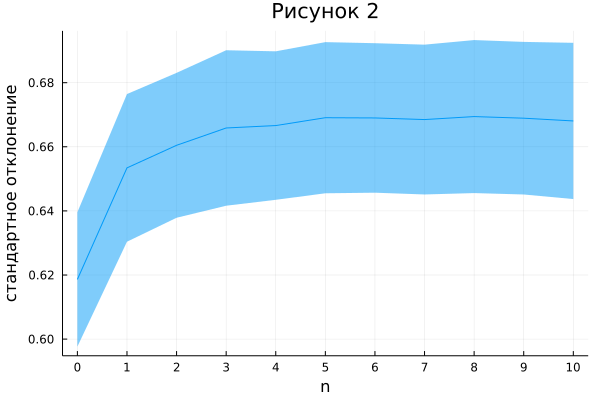

In [389]:
plot(ns, a, ribbon=b, xlabel="n", ylabel="стандартное отклонение", title="Рисунок 2", label=nothing, xticks=0:10)

## Проблема увеличения $n$
Увеличение $n$ ведет к увеличению технической информации в сети: загрузка маршрутизатора пропорциональна числу соседей в радиусе $n$.

In [84]:
g

{200, 400} undirected simple Int64 graph

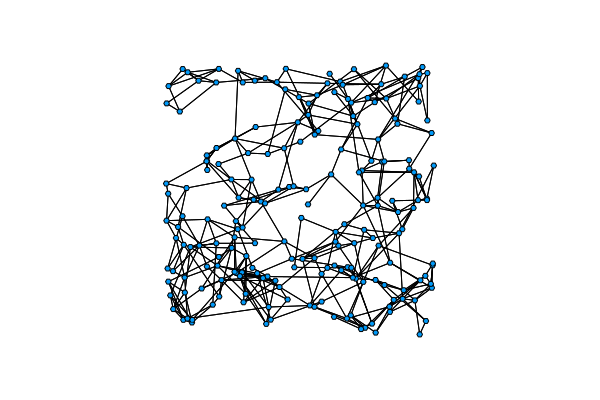

In [85]:
plot(g; x, y, curves=false)

In [400]:
@time gs, ms, ss = test_g(g, 0:20; op=+)
# @time gs2, ms2 = test_g(g, ns; op=max)
# plot(ns, [gs, gs2])

 28.320065 seconds (172.11 M allocations: 26.381 GiB, 23.13% gc time)


([0.6077887026134627, 0.6433171523316028, 0.6488006569793576, 0.6498457336582344, 0.6561559859788899, 0.6536629921994153, 0.6585579853389276, 0.656956355685487, 0.6548855791944891, 0.6538336204261719  …  0.6527739217566817, 0.6560033423013532, 0.6551679022190371, 0.6583213326727321, 0.6541288307865769, 0.6570985353705134, 0.6535160668100926, 0.655599758831234, 0.658742018428292, 0.6563885516862633], [[164.50252497475026, 140.13230867691323, 263.2838471615284, 844.589684103159, 285.4705152948471, 139.4179858201418, 561.560624393756, 128.0578194218058, 253.91923080769192, 141.7680123198768  …  162.03916960830392, 904.0758192418076, 472.5009649903501, 286.1447685523145, 285.80084199158006, 108.62403375966241, 114.77240227597724, 188.83846161538384, 770.8847011529884, 246.7610023899761], [185.97492025079748, 133.6451635483645, 243.9961800381996, 682.3142568574315, 292.9348506514935, 165.6109338906611, 514.2830471695283, 129.86660133398667, 284.23656763432365, 181.38940610593895  …  161.317

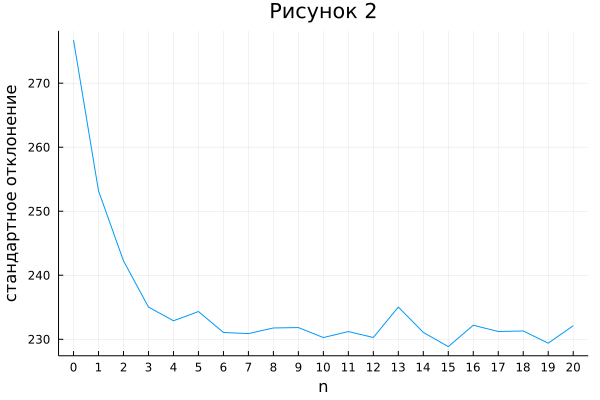

In [397]:
plot(0:20, std.(ms), xlabel="n", ylabel="стандартное отклонение", title="Рисунок 2", label=nothing, xticks=0:20)
savefig("std.png")
plot!()

In [423]:
g

{200, 400} undirected simple Int64 graph

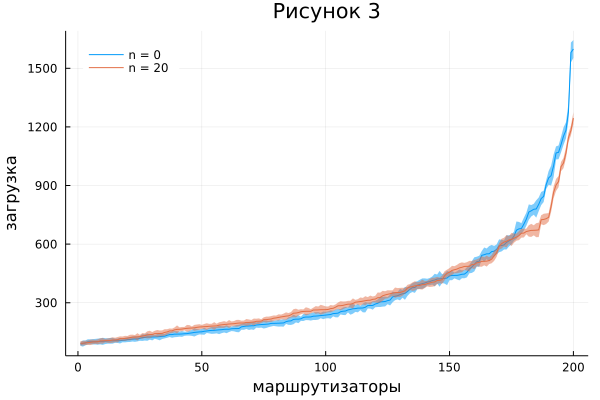

In [445]:
pix0 = sortperm(ms[1])
m0, s0 = ms[1][pix0], ss[1][pix0]
# m0, s0 = ms[1], ss[1]

pix20 = sortperm(ms[end])
m20, s20 = ms[end][pix20], ss[end][pix20]
# m20, s20 = ms[end], ss[end]

plot(legend=:topleft, title="Рисунок 3", ylabel="загрузка", xlabel="маршрутизаторы")
plot!(m0, ribbon=s0, label="n = 0")
plot!(m20, ribbon=s20, label="n = 20")
savefig("load.png")
plot!()

In [344]:
mean_and_std.(ms2)

11-element Vector{Tuple{Float64, Float64}}:
 (341.44298452015477, 275.0731561634773)
 (342.26571889281104, 251.21194396757076)
 (344.9695121548784, 245.05022665837035)
 (343.06927160728395, 241.02141659741375)
 (339.91975995240057, 239.1218375725087)
 (340.82978195218044, 240.44854614877394)
 (343.15328556714434, 243.84797624928137)
 (343.02065969340305, 243.41490554241832)
 (344.1069722802772, 244.0211270253697)
 (343.05403525964743, 244.10023578776224)
 (343.2986709632903, 242.2306963274655)

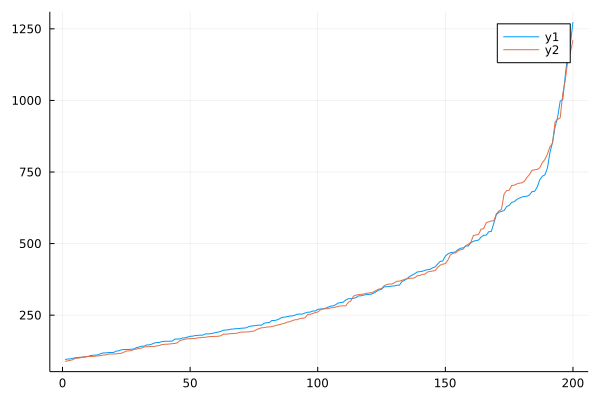

In [353]:
plot([sort(mi), sort(mj)])

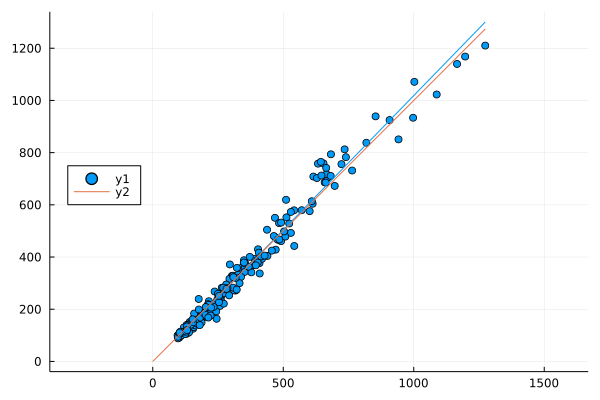

In [350]:
mi = ms[end]
mj = ms2[end]
plot(aspect_ratio=:equal, legend=:left)
scatter!(mi, mj; smooth=true)
maxm = max(mi..., mj...)
plot!([0, maxm], [0, maxm])

In [427]:
nload = [[length(neighborhood(g, v, n)) for v in vertices(g)] for n in 0:20]

21-element Vector{Vector{Int64}}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [4, 3, 3, 6, 6, 4, 7, 5, 6, 4  …  4, 5, 6, 7, 4, 4, 4, 5, 5, 7]
 [11, 9, 8, 22, 16, 12, 18, 13, 14, 12  …  12, 20, 20, 20, 12, 10, 11, 19, 16, 21]
 [27, 21, 24, 60, 40, 26, 36, 26, 33, 30  …  30, 53, 56, 38, 36, 23, 27, 40, 36, 44]
 [48, 43, 50, 100, 67, 51, 71, 49, 60, 53  …  53, 101, 86, 57, 76, 44, 54, 59, 60, 63]
 [70, 71, 78, 134, 89, 72, 113, 71, 81, 78  …  75, 153, 117, 79, 116, 69, 83, 80, 86, 83]
 [94, 96, 100, 160, 112, 89, 140, 91, 103, 106  …  102, 186, 152, 110, 148, 90, 119, 105, 118, 104]
 [120, 125, 134, 181, 139, 113, 168, 114, 134, 129  …  138, 192, 176, 134, 170, 119, 157, 140, 157, 134]
 [154, 158, 170, 193, 175, 143, 193, 144, 170, 168  …  174, 194, 192, 154, 187, 159, 180, 174, 181, 164]
 [178, 192, 187, 197, 198, 175, 200, 166, 187, 191  …  191, 198, 200, 181, 193, 178, 196, 191, 194, 186]
 [193, 199, 199, 200, 200, 195, 200, 186, 199, 200  …  194, 200, 200, 191, 1

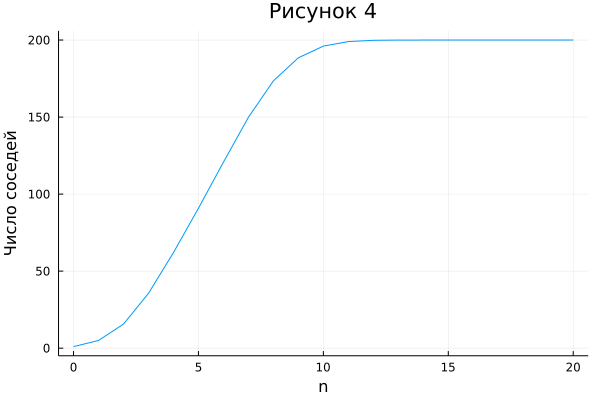

In [431]:
mnl = mean.(nload)
plot(legend=:topleft, title="Рисунок 4", ylabel="Число соседей", xlabel="n")
plot!(0:20, mnl, label=nothing)
savefig("neigborhood.png")
plot!()

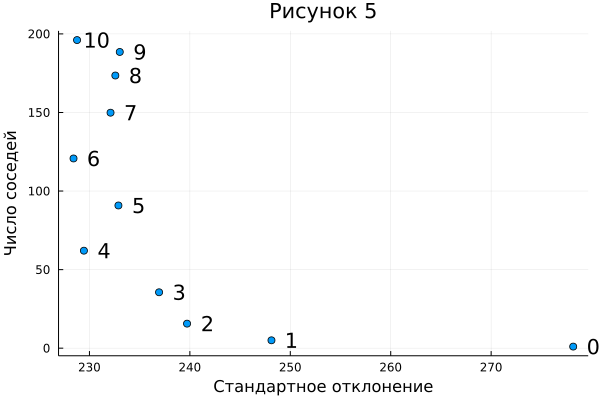

In [447]:
ix = 1:11
plot(title="Рисунок 5", xlabel="Стандартное отклонение", ylabel="Число соседей")
scatter!(std.(ms)[ix], mnl[ix], label=nothing)
annotate!(std.(ms)[ix] .+ 2, mnl[ix], 0:10)
savefig("std_info.png")
plot!()

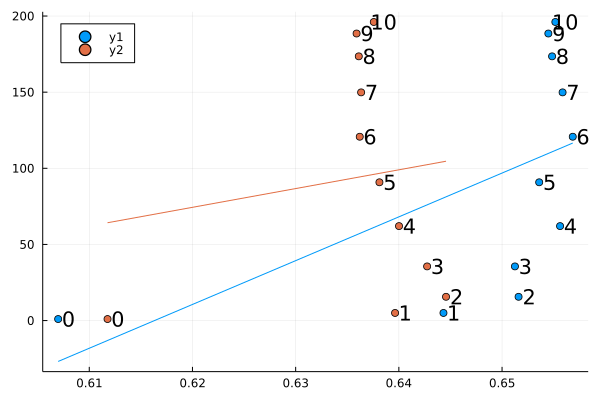

In [369]:
scatter(gs, mnl, smooth=true, datalabel=ns, legend=:topleft)
scatter!(gs2, mnl, smooth=true, datalabel=ns, legend=:topleft)
annotate!(gs .+ 0.001, mnl, ns)
annotate!(gs2 .+ 0.001, mnl, ns)

11-element Vector{Vector{Int64}}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
 [4, 3, 3, 6, 6, 4, 7, 5, 6, 4  …  4, 5, 6, 7, 4, 4, 4, 5, 5, 7]
 [11, 9, 8, 22, 16, 12, 18, 13, 14, 12  …  12, 20, 20, 20, 12, 10, 11, 19, 16, 21]
 [27, 21, 24, 60, 40, 26, 36, 26, 33, 30  …  30, 53, 56, 38, 36, 23, 27, 40, 36, 44]
 [48, 43, 50, 100, 67, 51, 71, 49, 60, 53  …  53, 101, 86, 57, 76, 44, 54, 59, 60, 63]
 [70, 71, 78, 134, 89, 72, 113, 71, 81, 78  …  75, 153, 117, 79, 116, 69, 83, 80, 86, 83]
 [94, 96, 100, 160, 112, 89, 140, 91, 103, 106  …  102, 186, 152, 110, 148, 90, 119, 105, 118, 104]
 [120, 125, 134, 181, 139, 113, 168, 114, 134, 129  …  138, 192, 176, 134, 170, 119, 157, 140, 157, 134]
 [154, 158, 170, 193, 175, 143, 193, 144, 170, 168  …  174, 194, 192, 154, 187, 159, 180, 174, 181, 164]
 [178, 192, 187, 197, 198, 175, 200, 166, 187, 191  …  191, 198, 200, 181, 193, 178, 196, 191, 194, 186]
 [193, 199, 199, 200, 200, 195, 200, 186, 199, 200  …  194, 200, 200, 191, 1

In [233]:
# Проверить что op=max работает правильно

In [267]:
g0 = Graph(6)
add_edge!(g0, 1, 2)
add_edge!(g0, 2, 3)
add_edge!(g0, 3, 4)
add_edge!(g0, 1, 5)
add_edge!(g0, 5, 6)
add_edge!(g0, 6, 4)

sn = SimpleNet(g0)

SimpleNet({6, 6} undirected simple Int64 graph, Graphs.FloydWarshallState{Int64, Int64}([0 1 … 1 2; 1 0 … 2 3; … ; 1 2 … 0 1; 2 3 … 1 0], [0 1 … 1 5; 2 0 … 1 4; … ; 5 1 … 0 5; 5 3 … 6 0]), Flow[], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [268]:
i = 1
j = 4
routes = [[i]]

while any(r -> r[end] != j, routes)
    new_routes = []
    for r in routes
        if r[end] == j
            push!(new_routes, r)
            continue
        end
        qs = next_vertex(sn.g, sn.a, r[end], j)
        for q in qs
            push!(new_routes, [r; q])
        end
    end
    routes = copy(new_routes)
end
routes

2-element Vector{Any}:
 [1, 2, 3, 4]
 [1, 5, 6, 4]

In [290]:
using Test

In [341]:

@testset "1" begin
    sn.loads = [10, 2, 2, 10, 1, 1]
    @test hopn(sn, i, j, 1; op=+) == 5
    @test hopn(sn, i, j, 1; op=max) == 5
    @test hopn(sn, i, j, 2; op=+) == 5
    @test hopn(sn, i, j, 2; op=max) == 5
    @test hopn(sn, i, j, 3; op=+) == 5
    # @test hopn(sn, i, j, 3; op=max) == 5
end

@testset "2" begin
    sn.loads = [10, 2, 1, 10, 3, 1]
    @test hopn(sn, i, j, 1; op=+) == 2
    @test hopn(sn, i, j, 1; op=max) == 2
    @test hopn(sn, i, j, 2; op=+) == 2
    @test hopn(sn, i, j, 2; op=max) == 2
    @test hopn(sn, i, j, 3; op=+) == 2
    # @test hopn(sn, i, j, 3; op=max) == 2
end

@testset "3" begin
    sn.loads = [10, 3, 3, 10, 4, 1]
    @test hopn(sn, i, j, 1; op=+) == 2
    @test hopn(sn, i, j, 1; op=max) == 2
    @test hopn(sn, i, j, 2; op=+) == 5
    @test hopn(sn, i, j, 2; op=max) == 2
    @test hopn(sn, i, j, 3; op=+) == 5
    # @test hopn(sn, i, j, 3; op=max) == 2
end

Test Summary: | Pass  Total
1             |    5      5
Test Summary: | Pass  Total
2             |    5      5
Test Summary: | Pass  Total
3             |    5      5


Test.DefaultTestSet("3", Any[], 5, false, false)

## Выводы из моделирования
1. Для `op = +` увеличение n в целом ведет к улучшению результата.
2. Менее оптимальные значения для больших $n$ можно объяснить, во-первых, случайностью, во-вторых, тем, что наша стратегия не оптимальная
3. `op = max` не является хорошей метрикой, ведущей к равному распределению. Однако она занижает максимумы.
4. $n = 0 \rightarrow n = 1$ - самый сильный скачок в оптимальности и незначительный рост технической загрузки. Ведет к предположению, что нет необходимости во всей информации.
5. Говорят, что оптимальные алгоритмы для больших $n$ требуют больших вычислений.
5. Общий вывод, что необходимо сосредоточиться на небольших $n$.

## Прежде всего следует оформить результаты.